In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

from JPAS_DA import global_setup
from JPAS_DA.data import data_loaders
from JPAS_DA.data import generate_toy_data
from JPAS_DA.models import model_building_tools
from JPAS_DA.training import save_load_tools
from JPAS_DA.evaluation import evaluation_tools

import os
import torch
import numpy as np
from sklearn.manifold import TSNE

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from JPAS_DA.utils import plotting_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib inline

from JPAS_DA.utils import aux_tools
aux_tools.set_seed(42)

/home/dlopez/tmp/pip-tmp/ipykernel_771370/550949071.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_dict = {cls: plt.cm.get_cmap("tab10")(i) for i, cls in enumerate(np.arange(n_classes))}


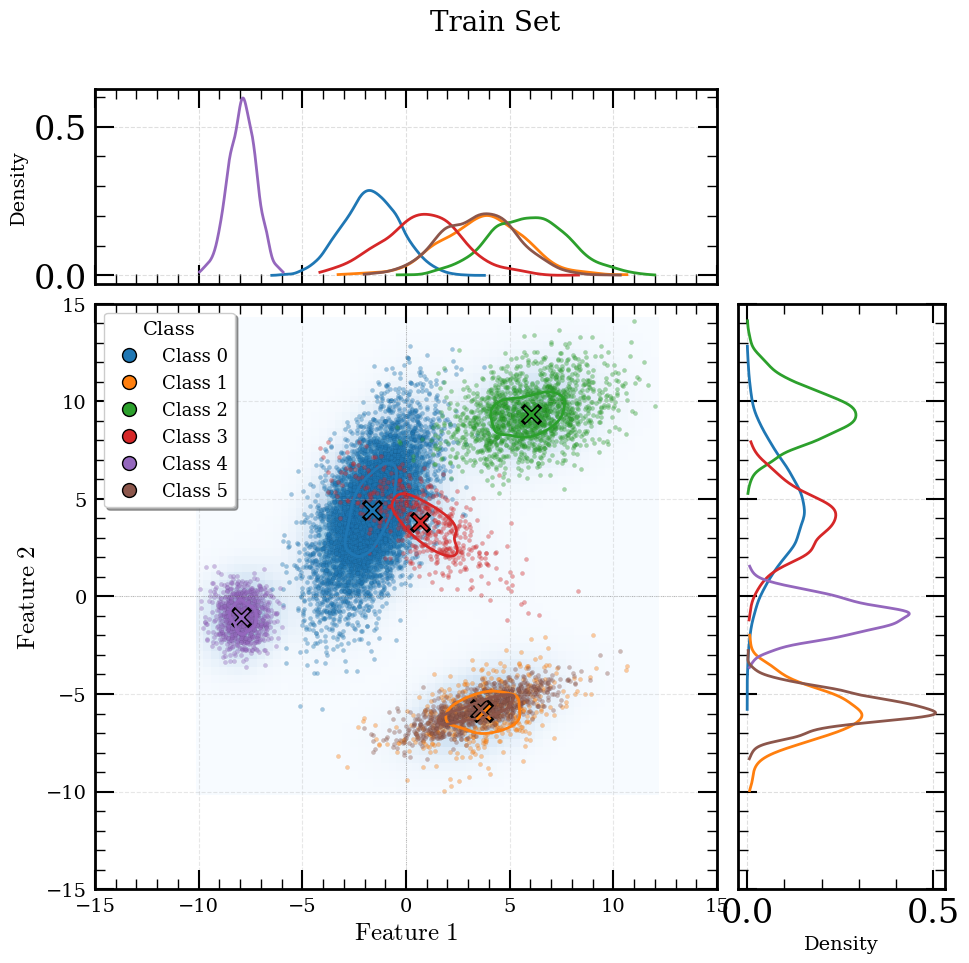

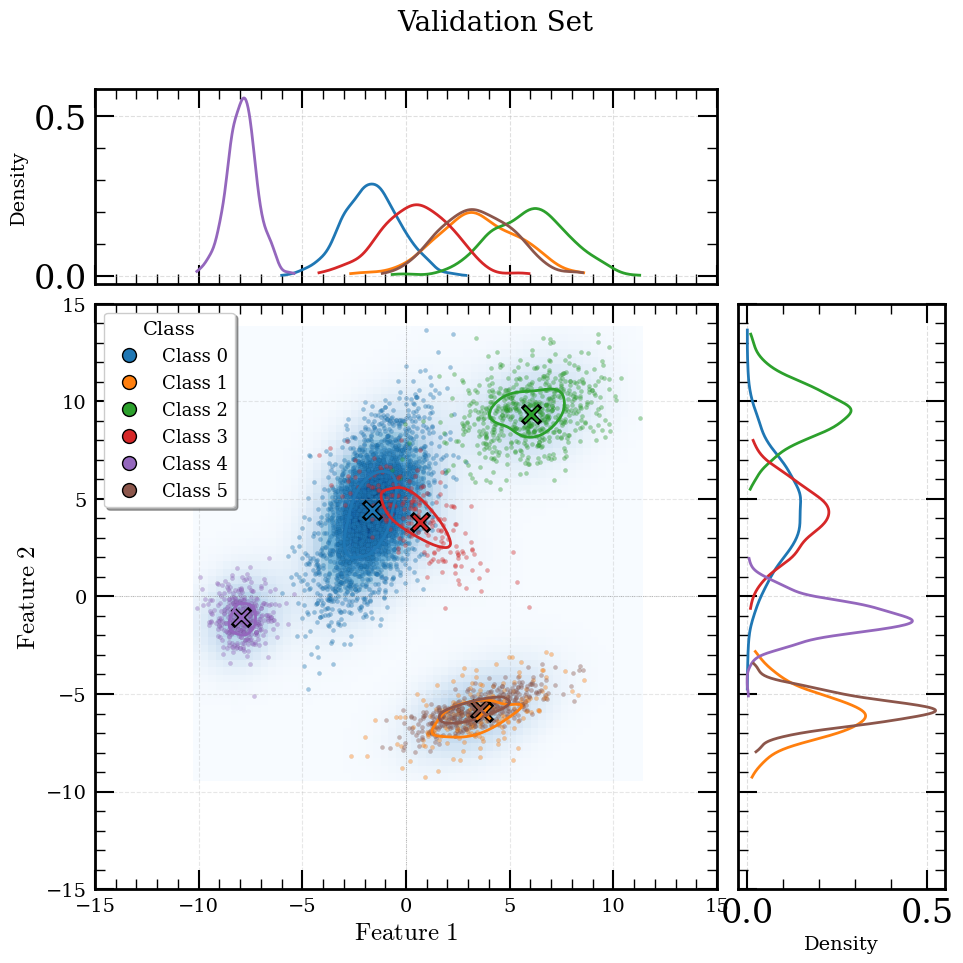

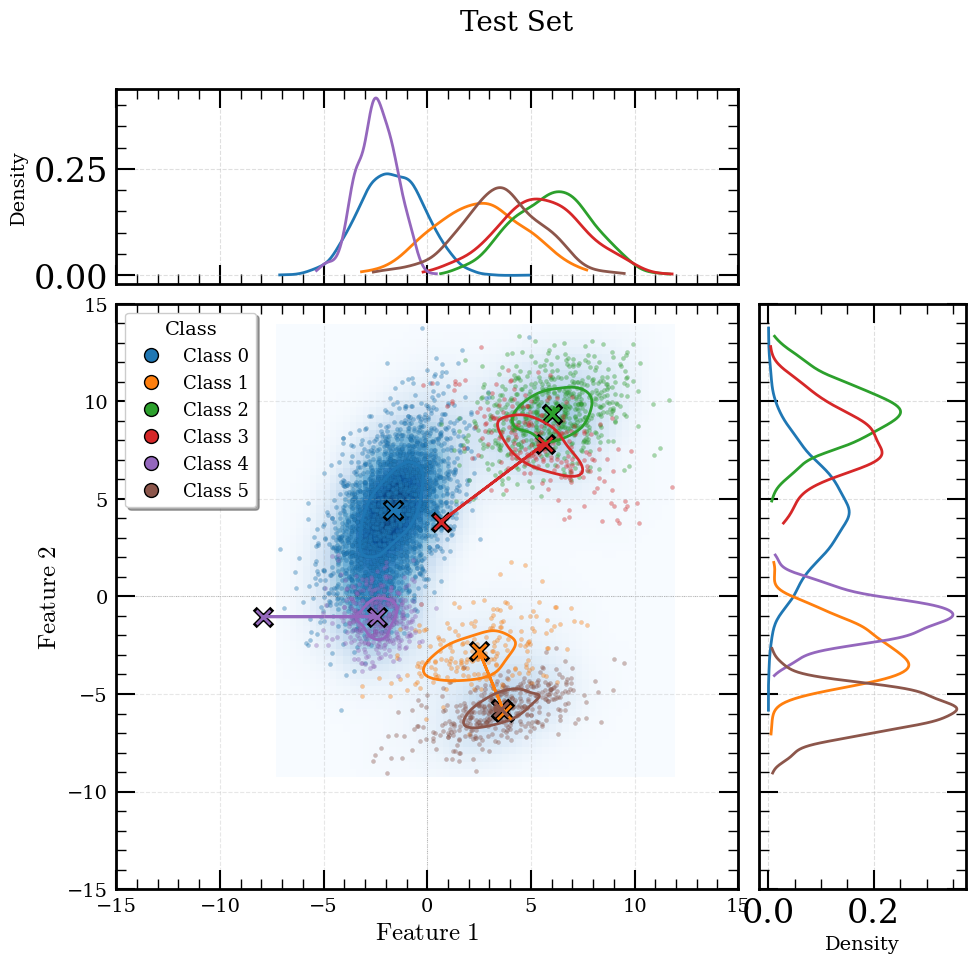

In [2]:
# === Shared Parameters ===
n_classes = 6
n_features = 2
class_center_range = [(-10, 10), (-10, 10)]
cov_scale_range = (0.1, 1.1)
class_proportions = np.array([0.55, 0.05, 0.15, 0.05, 0.1, 0.1])
assert np.isclose(class_proportions.sum(), 1.0)

# === Sample Sizes and Seeds ===
n_samples_train = 10000
n_samples_val = 4000
n_samples_test = 4000
n_samples_train_DA = 4000
n_samples_val_DA = 4000

seed_structure = 1     # Used to define centers and covariances
seed_train = 42        # Ensures different train/val/test samples
seed_val = 13
seed_test = 0
seed_train_DA = 2
seed_val_DA = 3
seed_shift = 4

# === Generate fixed shared structure for train/val ===
shared_centers, shared_covs = generate_toy_data.generate_centers_covs(n_classes, n_features, class_center_range, cov_scale_range, seed_structure)

# === Generate train/val sets with different seeds but same structure ===
xx_train, yy_train, train_counts = generate_toy_data.generate_dataset_from_structure(n_samples_train, shared_centers, shared_covs, class_proportions, seed=seed_train)
xx_val, yy_val, val_counts = generate_toy_data.generate_dataset_from_structure(n_samples_val, shared_centers, shared_covs, class_proportions, seed=seed_val)

# === Generate test set with shifted centers and covs ===
shifted_centers, shifted_covs = generate_toy_data.shift_centers_covs(shared_centers, shared_covs, center_shift=1.0, cov_shift=0.5, seed=seed_shift)

shifted_centers = np.array([
[-1.65955991,  4.40648987],
[ 2.50439001, -2.81095501],
[ 6.01489137,  9.36523151],
[ 5.6633057 ,  7.83754228],
[-2.43547987, -1.04212948],
[ 3.57671066, -5.76743768]
])
xx_test, yy_test, test_counts = generate_toy_data.generate_dataset_from_structure(n_samples_test, shifted_centers, shifted_covs, class_proportions, seed=seed_test)
xx_train_DA, yy_train_DA, _ = generate_toy_data.generate_dataset_from_structure(n_samples_val_DA, shifted_centers, shifted_covs, class_proportions, seed=seed_val_DA)
xx_val_DA, yy_val_DA, _ = generate_toy_data.generate_dataset_from_structure(n_samples_val_DA, shifted_centers, shifted_covs, class_proportions, seed=seed_val_DA)


# === Visualize sets ===
color_dict = {cls: plt.cm.get_cmap("tab10")(i) for i, cls in enumerate(np.arange(n_classes))}

fig1, ax_main1 = plotting_utils.plot_2d_classification_with_kde(xx_train["OBS"], yy_train["SPECTYPE_int"], title="Train Set", class_color_dict=color_dict)
for i in range(n_classes):
    ax_main1.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main1.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
ax_main1.set_xlim(-15, 15)
ax_main1.set_ylim(-15, 15)
plt.show()

fig2, ax_main2 = plotting_utils.plot_2d_classification_with_kde(xx_val["OBS"], yy_val["SPECTYPE_int"], title="Validation Set", class_color_dict=color_dict)
for i in range(n_classes):
    ax_main2.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main2.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
ax_main2.set_xlim(-15, 15)
ax_main2.set_ylim(-15, 15)
plt.show()

fig3, ax_main3 = plotting_utils.plot_2d_classification_with_kde(xx_test["OBS"], yy_test["SPECTYPE_int"], title="Test Set", class_color_dict=color_dict)
for i in range(n_classes):
    ax_main3.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main3.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
for i in range(n_classes):
    ax_main3.scatter(shifted_centers[i, 0], shifted_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main3.scatter(shifted_centers[i, 0], shifted_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
for i in range(n_classes):
    delta = shifted_centers[i] - shared_centers[i]
    ax_main3.arrow(shared_centers[i, 0], shared_centers[i, 1], delta[0], delta[1], color=color_dict[i], linewidth=2, head_width=0.2, length_includes_head=True)
ax_main3.set_xlim(-15, 15)
ax_main3.set_ylim(-15, 15)
plt.show()

In [3]:
path_load_no_DA = os.path.join(global_setup.path_models, "06_example_model")
path_load_DA = os.path.join(global_setup.path_models, "07_example_model_DA")

In [4]:
dset_val_no_DA = data_loaders.DataLoader(xx_val, yy_val)
dset_val_DA = data_loaders.DataLoader(xx_val_DA, yy_val_DA)
dset_test = data_loaders.DataLoader(xx_test, yy_test)

2025-09-26 13:21:32,279 - INFO - ├── 💿 Initializing DataLoader object with 4000 samples...
2025-09-26 13:21:32,280 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 2200 (55.00%), 1: 200 (5.00%), 2: 600 (15.00%), 3: 200 (5.00%), 4: 400 (10.00%), 5: 400 (10.00%)]
2025-09-26 13:21:32,280 - INFO - ├── 💿 Initializing DataLoader object with 4000 samples...
2025-09-26 13:21:32,280 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 2200 (55.00%), 1: 200 (5.00%), 2: 600 (15.00%), 3: 200 (5.00%), 4: 400 (10.00%), 5: 400 (10.00%)]
2025-09-26 13:21:32,281 - INFO - ├── 💿 Initializing DataLoader object with 4000 samples...
2025-09-26 13:21:32,281 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 2200 (55.00%), 1: 200 (5.00%), 2: 600 (15.00%), 3: 200 (5.00%), 4: 400 (10.00%), 5: 400 (10.00%)]


In [5]:
_, model_encoder_no_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_no_DA, "model_encoder.pt"), model_building_tools.create_mlp)
_, model_downstream_no_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_no_DA, "model_downstream.pt"), model_building_tools.create_mlp)
model_encoder_no_DA.eval()
model_downstream_no_DA.eval()

_, model_encoder_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_DA, "model_encoder.pt"), model_building_tools.create_mlp)
_, model_downstream_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_DA, "model_downstream.pt"), model_building_tools.create_mlp)
model_encoder_DA.eval()
model_downstream_DA.eval()

_ = evaluation_tools.compare_model_parameters(model_downstream_no_DA, model_downstream_DA, rtol=1e-2, atol=1e-2)

config {'input_dim': 2, 'hidden_layers': [32, 32, 32], 'dropout_rates': [0.01, 0.01, 0.01], 'output_dim': 2, 'use_batchnorm': True, 'use_layernorm_at_output': False, 'init_method': 'xavier'}
config {'input_dim': 2, 'hidden_layers': [16, 8, 8], 'dropout_rates': [0.01, 0.01, 0.01], 'output_dim': 6, 'use_batchnorm': True, 'use_layernorm_at_output': False, 'init_method': 'xavier'}
config {'input_dim': 2, 'hidden_layers': [32, 32, 32], 'dropout_rates': [0.001, 0.001, 0.001], 'output_dim': 2, 'use_batchnorm': True, 'use_layernorm_at_output': False, 'init_method': 'xavier'}
config {'input_dim': 2, 'hidden_layers': [16, 8, 8], 'dropout_rates': [0.001, 0.001, 0.001], 'output_dim': 6, 'use_batchnorm': True, 'use_layernorm_at_output': False, 'init_method': 'xavier'}
✅ All parameters match.


In [6]:
xx, yy_true = dset_val_no_DA(batch_size=dset_val_no_DA.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_no_DA(xx)
        logits = model_downstream_no_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_val_no_DA = yy_true.cpu().numpy()
features_val_no_DA = features_.cpu().numpy()
yy_pred_P_val_no_DA = yy_pred_P.cpu().numpy()
yy_pred_val_no_DA = np.argmax(yy_pred_P_val_no_DA, axis=1)


xx, yy_true = dset_val_DA(batch_size=dset_val_DA.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_DA(xx)
        logits = model_downstream_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_val_DA = yy_true.cpu().numpy()
features_val_DA = features_.cpu().numpy()
yy_pred_P_val_DA = yy_pred_P.cpu().numpy()
yy_pred_val_DA = np.argmax(yy_pred_P_val_DA, axis=1)


xx, yy_true = dset_test(batch_size=dset_test.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_no_DA(xx)
        logits = model_downstream_no_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_test = yy_true.cpu().numpy()
features_test_no_DA = features_.cpu().numpy()
yy_pred_P_test_no_DA = yy_pred_P.cpu().numpy()
yy_pred_test_no_DA = np.argmax(yy_pred_P_test_no_DA, axis=1)


xx, yy_true = dset_test(batch_size=dset_test.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_DA(xx)
        logits = model_downstream_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_test = yy_true.cpu().numpy()
features_test_DA = features_.cpu().numpy()
yy_pred_P_test_DA = yy_pred_P.cpu().numpy()
yy_pred_test_DA = np.argmax(yy_pred_P_test_DA, axis=1)

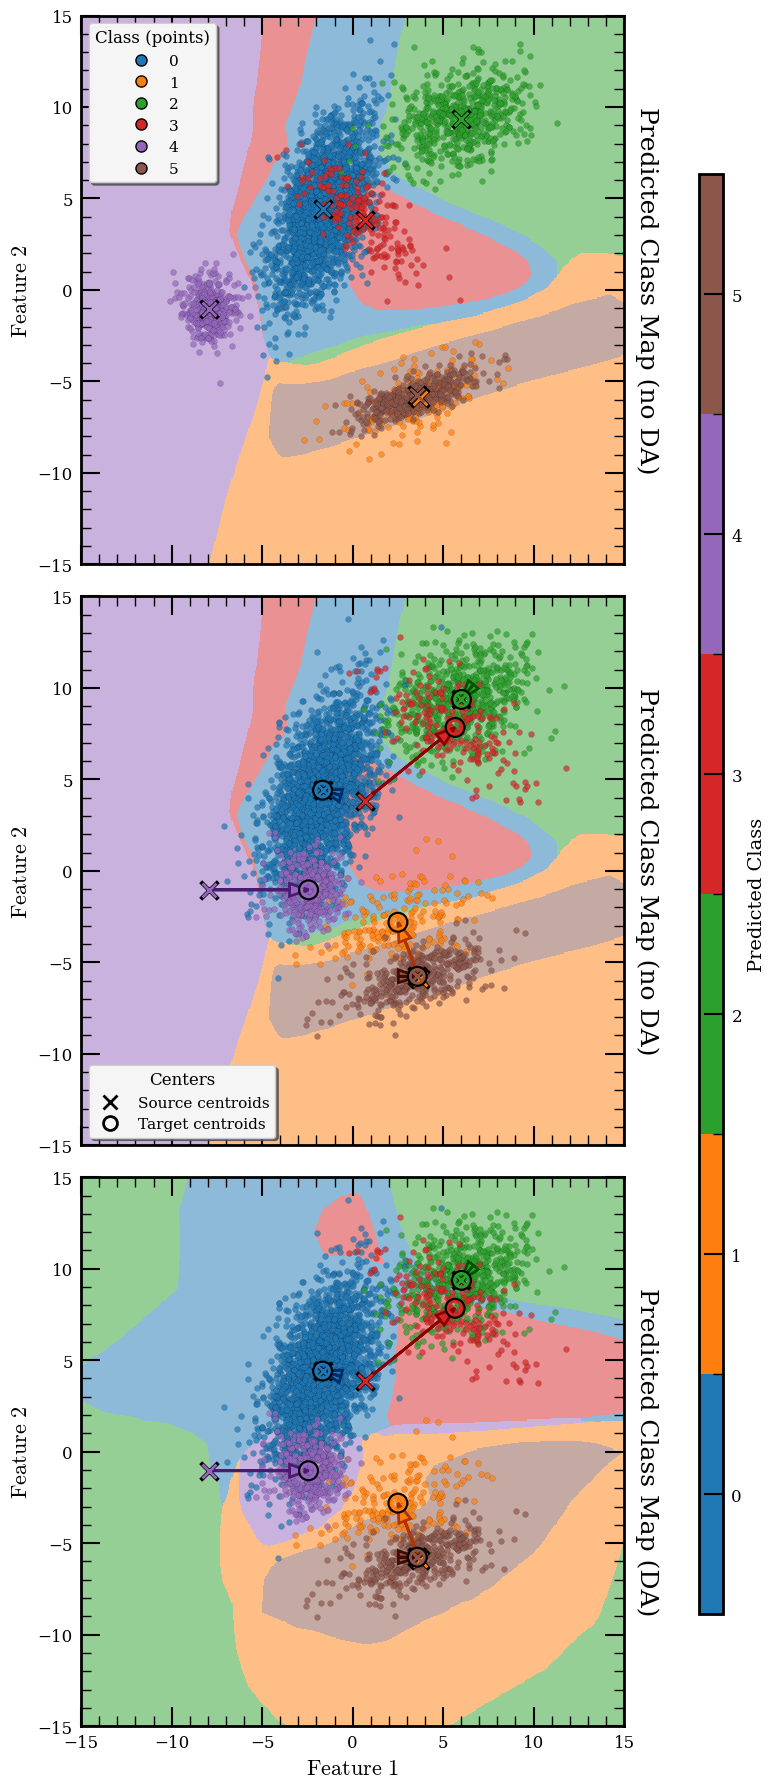

In [7]:
# ---- Bounds & grid ----
x_min, x_max = -15, 15
y_min, y_max = -15, 15
grid_res = 512

xx_vals = np.linspace(x_min, x_max, grid_res)
yy_vals = np.linspace(y_min, y_max, grid_res)
xx_mesh, yy_mesh = np.meshgrid(xx_vals, yy_vals)
grid_points = np.stack([xx_mesh.ravel(), yy_mesh.ravel()], axis=1)

# Build the grid tensor on CPU, move to the model's device for each forward pass
xx_grid_cpu = torch.tensor(grid_points, dtype=torch.float32, device="cpu")

# ---- Colors (consistent across panels) ----
try:
    n_classes = len(dset_val_no_DA.class_labels)
    class_labels = np.array(dset_val_no_DA.class_labels)
    class_colors = [color_dict[int(i)] for i in range(n_classes)]
except Exception:
    class_labels = np.unique(dset_val_no_DA.yy["SPECTYPE_int"])
    n_classes = len(class_labels)
    cmap_base = plt.cm.get_cmap("tab10")
    class_colors = [cmap_base(i % cmap_base.N) for i in range(n_classes)]

cmap = mpl.colors.ListedColormap(class_colors)
norm = mpl.colors.BoundaryNorm(np.arange(n_classes + 1) - 0.5, ncolors=n_classes)

# ---- Helper: predict on grid with a (encoder, downstream) pair ----
def predict_grid(encoder, downstream, xx_grid_cpu, device):
    with torch.no_grad():
        feats = encoder(xx_grid_cpu.to(device))
        logits = downstream(feats)
        yy_pred = torch.softmax(logits, dim=1).argmax(dim=1)
    Z = yy_pred.view(grid_res, grid_res).cpu().numpy().astype(float)
    return Z

# Devices (assume models are already on appropriate devices)
dev_no_DA = next(model_encoder_no_DA.parameters()).device
dev_DA    = next(model_encoder_DA.parameters()).device

# ---- Compute predicted grids ----
Z_noDA_val  = predict_grid(model_encoder_no_DA, model_downstream_no_DA, xx_grid_cpu, dev_no_DA)
Z_noDA_test = Z_noDA_val  # same models; reuse prediction for test overlay
Z_DA_test   = predict_grid(model_encoder_DA, model_downstream_DA, xx_grid_cpu, dev_DA)

# ---- Figure with THREE VERTICAL PANELS (shared axes) ----
fig, axes = plt.subplots(3, 1, figsize=(8, 18), sharex=True, sharey=True)
titles = [
    "Predicted Class Map (no DA)",
    "Predicted Class Map (no DA)",
    "Predicted Class Map (DA)",
]

for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.tick_params(labelsize=12)

# Left y-label on the top panel; shared x-label on the bottom
axes[0].set_ylabel(r"$\mathrm{Feature~2}$", fontsize=16)
axes[1].set_ylabel(r"$\mathrm{Feature~2}$", fontsize=16)
axes[2].set_ylabel(r"$\mathrm{Feature~2}$", fontsize=16)
axes[-1].set_xlabel(r"$\mathrm{Feature~1}$", fontsize=16)

# Draw the “titles” on the RIGHT like y-labels
for ax, title in zip(axes, titles):
    ax.text(
        1.02, 0.5, title, transform=ax.transAxes,
        rotation=-90, va='center', ha='left', fontsize=18
    )

# ---- Panel 1: no-DA + validation points + shared centers (only) ----
ax0 = axes[0]
pcm0 = ax0.pcolormesh(xx_mesh, yy_mesh, Z_noDA_val, cmap=cmap, norm=norm, shading='nearest', alpha=0.5)

for i, label in enumerate(class_labels):
    mask = (dset_val_no_DA.yy["SPECTYPE_int"] == label)
    tmp = dset_val_no_DA.xx["OBS"][mask]
    ax0.scatter(tmp[:, 0], tmp[:, 1], s=18, alpha=0.7, color=class_colors[i],
                edgecolor='black', linewidth=0.1)

for i in range(n_classes):
    ax0.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black',
                s=160, linewidth=3, zorder=1)
    ax0.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=class_colors[i],
                s=100, linewidth=2, zorder=2)

# ---- Panel 2: no-DA + test points + centers + arrows ----
ax1 = axes[1]
pcm1 = ax1.pcolormesh(xx_mesh, yy_mesh, Z_noDA_test, cmap=cmap, norm=norm, shading='nearest', alpha=0.5)

for i, label in enumerate(class_labels):
    mask = (dset_test.yy["SPECTYPE_int"] == label)
    tmp = dset_test.xx["OBS"][mask]
    ax1.scatter(tmp[:, 0], tmp[:, 1], s=18, alpha=0.7, color=class_colors[i],
                edgecolor='black', linewidth=0.1)

for i in range(n_classes):
    ax1.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black',
                s=160, linewidth=3, zorder=1)
    ax1.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=class_colors[i],
                s=100, linewidth=2, zorder=2)
    ax1.scatter(shifted_centers[i, 0], shifted_centers[i, 1], marker="o", facecolor='none',
                edgecolor='black', s=160, linewidth=2.5, zorder=3)
    ax1.scatter(shifted_centers[i, 0], shifted_centers[i, 1], marker="o", facecolor='none',
                edgecolor=class_colors[i], s=100, linewidth=2.0, zorder=4)
    delta = shifted_centers[i] - shared_centers[i]
    tmp_color = np.array(class_colors[i], dtype=float)
    tmp_color[:3] = np.maximum(tmp_color[:3] - 0.3, 0.0)
    ax1.arrow(shared_centers[i, 0], shared_centers[i, 1], delta[0], delta[1],
              color=class_colors[i], linewidth=2, ec=tmp_color,
              head_width=0.7, length_includes_head=True, capstyle="projecting")

# ---- Panel 3: DA + test points + centers + arrows ----
ax2 = axes[2]
pcm2 = ax2.pcolormesh(xx_mesh, yy_mesh, Z_DA_test, cmap=cmap, norm=norm, shading='nearest', alpha=0.5)

for i, label in enumerate(class_labels):
    mask = (dset_test.yy["SPECTYPE_int"] == label)
    tmp = dset_test.xx["OBS"][mask]
    ax2.scatter(tmp[:, 0], tmp[:, 1], s=18, alpha=0.7, color=class_colors[i],
                edgecolor='black', linewidth=0.1)

for i in range(n_classes):
    ax2.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black',
                s=160, linewidth=3, zorder=1)
    ax2.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=class_colors[i],
                s=100, linewidth=2, zorder=2)
    ax2.scatter(shifted_centers[i, 0], shifted_centers[i, 1], marker="o", facecolor='none',
                edgecolor='black', s=160, linewidth=2.5, zorder=3)
    ax2.scatter(shifted_centers[i, 0], shifted_centers[i, 1], marker="o", facecolor='none',
                edgecolor=class_colors[i], s=100, linewidth=2.0, zorder=4)
    delta = shifted_centers[i] - shared_centers[i]
    tmp_color = np.array(class_colors[i], dtype=float)
    tmp_color[:3] = np.maximum(tmp_color[:3] - 0.3, 0.0)
    ax2.arrow(shared_centers[i, 0], shared_centers[i, 1], delta[0], delta[1],
              color=class_colors[i], linewidth=2, ec=tmp_color,
              head_width=0.7, length_includes_head=True, capstyle="projecting")

# ---- Two separate legends (same placement logic as before) ----
from matplotlib.lines import Line2D

# (1) Class legend on FIRST panel
class_handles = [
    Line2D([0], [0], marker='o', linestyle='None', markerfacecolor=class_colors[i],
           markeredgecolor='black', markersize=8, label=str(class_labels[i]))
    for i in range(n_classes)
]
leg_classes = ax0.legend(handles=class_handles, loc='upper left',
                         title="Class (points)", title_fontsize=12, fontsize=11,
                         fancybox=True, shadow=True, framealpha=0.9)
ax0.add_artist(leg_classes)

# (2) Centers legend on SECOND panel
center_handles = [
    Line2D([0], [0], marker='x', linestyle='None', color='black',
           markersize=10, markeredgewidth=2.0, label='Source centroids'),
    Line2D([0], [0], marker='o', linestyle='None', color='black',
           markerfacecolor='none', markersize=10, markeredgewidth=2.0, label='Target centroids'),
]
leg_centers = ax1.legend(handles=center_handles, loc='lower left',
                         title="Centers", title_fontsize=12, fontsize=11,
                         fancybox=True, shadow=True, framealpha=0.9)
ax1.add_artist(leg_centers)

# ---- One shared colorbar on the RIGHT of the whole figure ----
plt.tight_layout(rect=[0.0, 0.0, 0.85, 1.0])  # leave room for colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cax = fig.add_axes([0.88, 0.10, 0.03, 0.80])  # [left, bottom, width, height] in figure coords
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Predicted Class", fontsize=14)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(np.arange(n_classes))
try:
    cbar.set_ticklabels([str(lbl) for lbl in class_labels])
except Exception:
    pass

plt.savefig(os.path.join(global_setup.path_saved_figures, "toy_distributions_tripanel.png"),
            format="png", bbox_inches="tight")
plt.show()

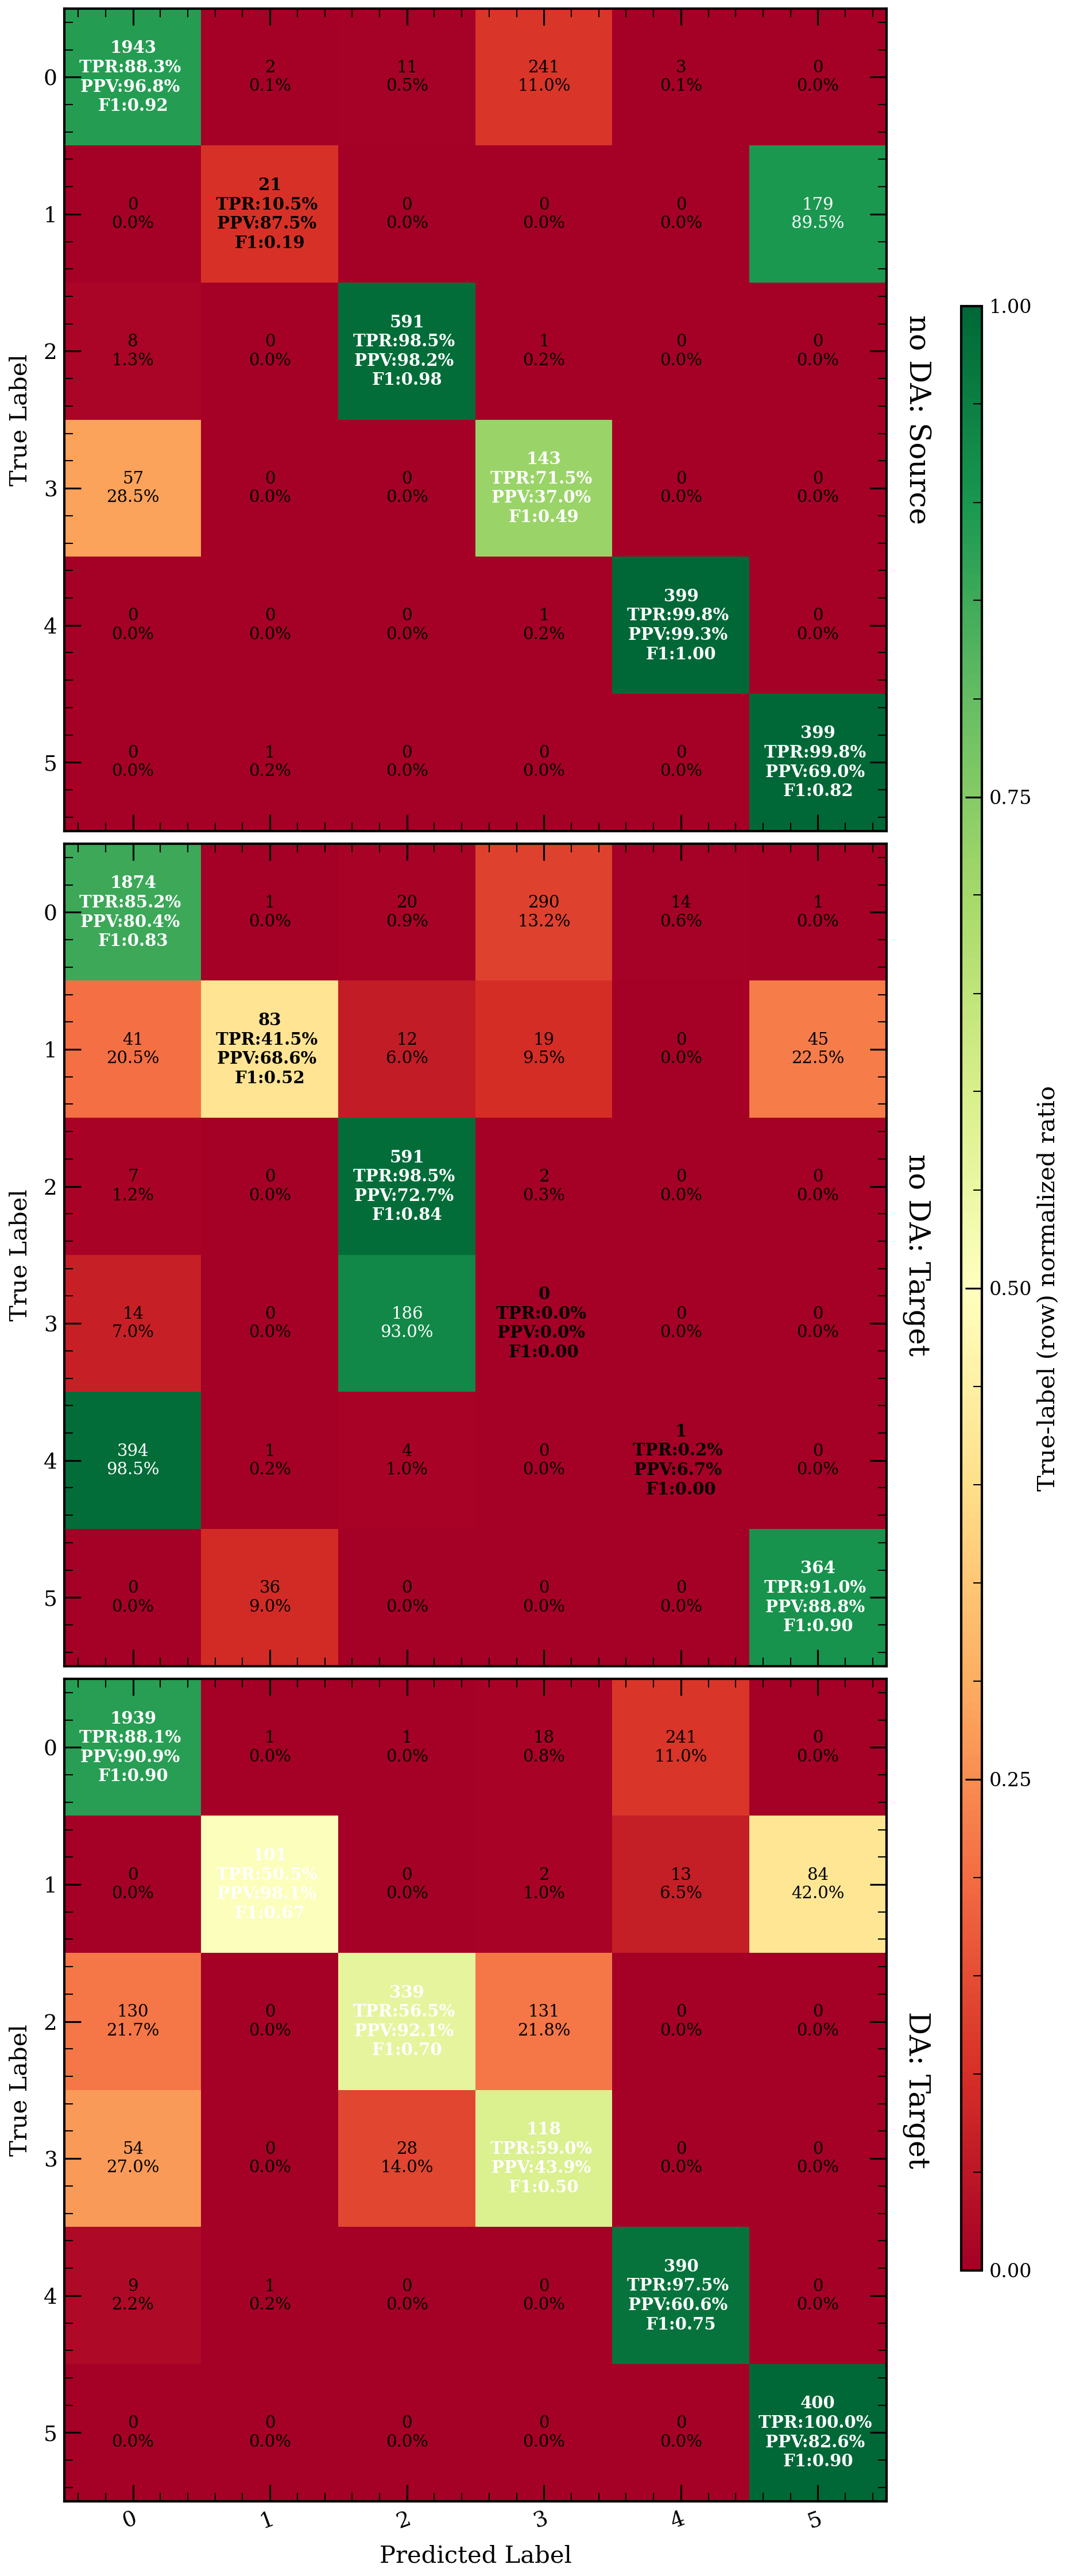

In [8]:
# ---- Bigger font config ----
FS_TITLE = 24
FS_LABEL = 20
FS_TICKS = 18
FS_CELL  = 14          # off-diagonal cell text
FS_CELL_DIAG = 14      # diagonal cell text
FS_CBAR_LABEL = 20
FS_CBAR_TICKS = 16
TICK_ROT = 20

# Config
class_names = np.arange(n_classes)  # or your custom names
cmap = plt.cm.RdYlGn
threshold_color = 0.5  # cell text color threshold based on cm_percent (0..1)

cases = [
    ("no DA: Source", yy_true_val_no_DA, yy_pred_P_val_no_DA),
    ("no DA: Target", yy_true_test,     yy_pred_P_test_no_DA),
    ("DA: Target",    yy_true_test,     yy_pred_P_test_DA),
]

# Color normalization for row-normalized proportion in [0, 1]
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)

# --- Three VERTICAL subpanels with shared axes ---
fig, axes = plt.subplots(3, 1, figsize=(12, 30), sharex=True, sharey=True)
fig.dpi = 150

# For shared colorbar
mappable_for_cbar = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable_for_cbar.set_array([])

# Shared limits/ticks for confusion matrices (note reversed y-limits to keep row 0 at top)
xlim = (-0.5, n_classes - 0.5)
ylim = (n_classes - 0.5, -0.5)  # reverse to match origin='upper'
ticks = np.arange(n_classes)

for ax, (title, yy_true, yy_pred_P) in zip(axes, cases):
    yy_pred = np.argmax(yy_pred_P, axis=1)

    # Confusion matrix with all classes present
    cm = np.zeros((n_classes, n_classes), dtype=int)
    valid = (yy_true >= 0) & (yy_true < n_classes)
    for t, p in zip(yy_true[valid], yy_pred[valid]):
        cm[int(t), int(p)] += 1

    # Row-normalized
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_percent = np.divide(cm, row_sums, where=row_sums != 0)

    # Matrix image (keep row 0 at the TOP)
    im = ax.imshow(cm_percent, interpolation='nearest', cmap=cmap, norm=norm, origin='upper')

    # Shared axes styling
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(class_names, fontsize=FS_TICKS)
    ax.set_yticklabels(class_names, fontsize=FS_TICKS)
    ax.set_aspect('equal', adjustable='box')  # square cells

    # Place the "title" on the RIGHT like a y-label
    ax.text(1.02, 0.5, title, transform=ax.transAxes,
            rotation=-90, va='center', ha='left', fontsize=FS_TITLE)

    # Per-class metrics
    precision = np.zeros(n_classes, dtype=float)
    recall    = np.zeros(n_classes, dtype=float)
    f1        = np.zeros(n_classes, dtype=float)
    for i in range(n_classes):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall[i]    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1[i]        = (2 * precision[i] * recall[i] / (precision[i] + recall[i])
                        if (precision[i] + recall[i]) > 0 else 0.0)

    # Cell annotations (counts + %; diagonal shows TPR/PPV/F1)
    for i in range(n_classes):
        for j in range(n_classes):
            count   = cm[i, j]
            percent = cm_percent[i, j] * 100 if row_sums[i, 0] != 0 else 0.0
            text_color = "white" if cm_percent[i, j] > threshold_color else "black"

            if i == j:
                text = (f"{count}\n"
                        f"TPR:{recall[i]*100:.1f}% "
                        f"\nPPV:{precision[i]*100:.1f}% "
                        f"\nF1:{f1[i]:.2f}")
                ax.text(j, i, text, ha="center", va="center",
                        color=text_color, fontsize=FS_CELL_DIAG, fontweight='bold', linespacing=1.2)
            else:
                text = f"{count}\n{percent:.1f}%"
                ax.text(j, i, text, ha="center", va="center",
                        color=text_color, fontsize=FS_CELL, linespacing=1.2)

# Labels: show y-label on middle panel, x-label on bottom panel
axes[0].set_ylabel('True Label', fontsize=FS_LABEL, labelpad=10)
axes[1].set_ylabel('True Label', fontsize=FS_LABEL, labelpad=10)
axes[2].set_ylabel('True Label', fontsize=FS_LABEL, labelpad=10)
plt.setp(axes[0].get_xticklabels(), visible=False)
plt.setp(axes[1].get_xticklabels(), visible=False)
axes[-1].set_xlabel('Predicted Label', fontsize=FS_LABEL, labelpad=10)
plt.setp(axes[-1].get_xticklabels(), rotation=TICK_ROT, ha="right", rotation_mode="anchor")

# Shared colorbar on the RIGHT
plt.tight_layout(rect=[0.0, 0.0, 0.90, 1.0])  # leave room for cbar
cax = fig.add_axes([0.92, 0.12, 0.02, 0.76])
cbar = fig.colorbar(mappable_for_cbar, cax=cax)
cbar.set_label("True-label (row) normalized ratio", fontsize=FS_CBAR_LABEL)
cbar.ax.tick_params(labelsize=FS_CBAR_TICKS)
cbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])

plt.savefig(os.path.join(global_setup.path_saved_figures, "toy_confusion_matrices_tripanel.pdf"),
            bbox_inches="tight")
plt.show()


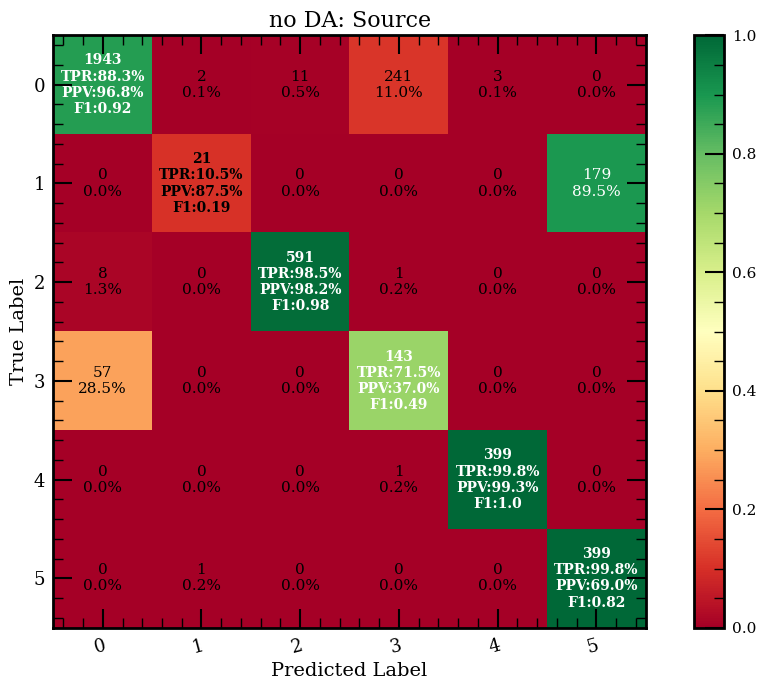

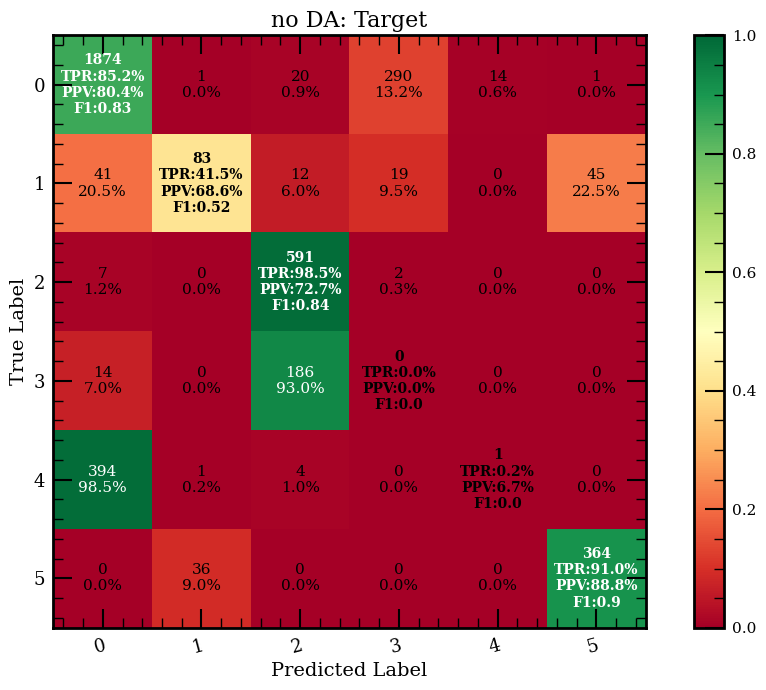

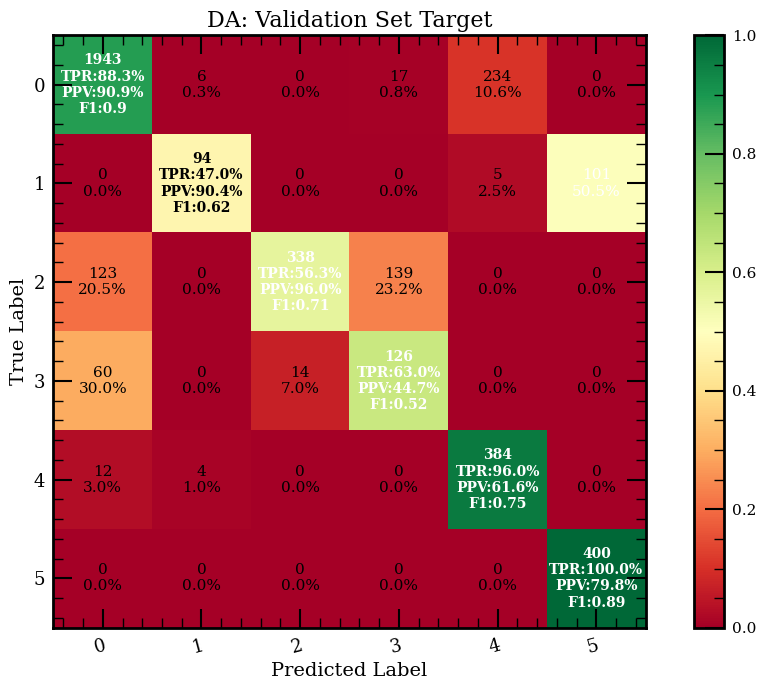

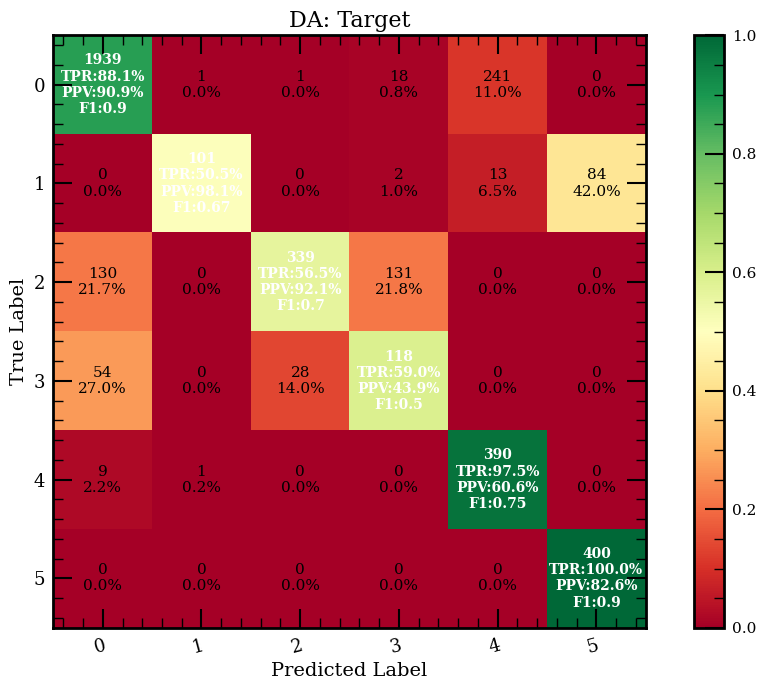

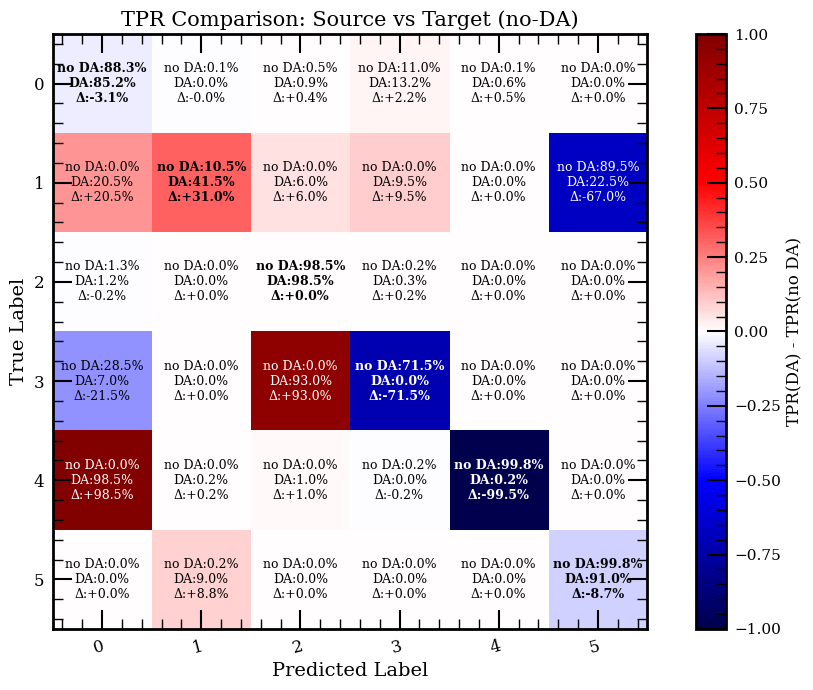

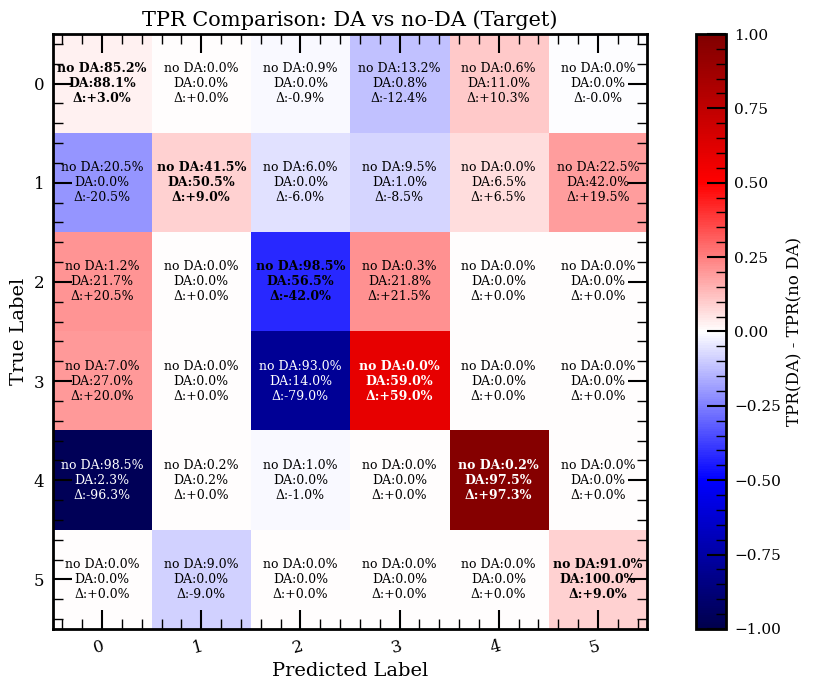

In [9]:
evaluation_tools.plot_confusion_matrix(
    yy_true_val_no_DA, yy_pred_P_val_no_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="no DA: Source"
)

evaluation_tools.plot_confusion_matrix(
    yy_true_test, yy_pred_P_test_no_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="no DA: Target"
)

evaluation_tools.plot_confusion_matrix(
    yy_true_val_DA, yy_pred_P_val_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="DA: Validation Set Target"
)

evaluation_tools.plot_confusion_matrix(
    yy_true_test, yy_pred_P_test_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="DA: Target"
)

evaluation_tools.compare_TPR_confusion_matrices(
    yy_true_val_no_DA,
    yy_pred_P_val_no_DA,
    yy_true_test,
    yy_pred_P_test_no_DA,
    class_names=np.arange(n_classes),
    figsize=(10, 7),
    cmap='seismic',
    title='TPR Comparison: Source vs Target (no-DA)',
    name_1 = "no DA",
    name_2 = "DA"
)
evaluation_tools.compare_TPR_confusion_matrices(
    yy_true_test,
    yy_pred_P_test_no_DA,
    yy_true_test,
    yy_pred_P_test_DA,
    class_names=np.arange(n_classes),
    figsize=(10, 7),
    cmap='seismic',
    title='TPR Comparison: DA vs no-DA (Target)',
    name_1 = "no DA",
    name_2 = "DA"
)


=== Source (no-DA) vs Target Metrics ===
Metric                        Source (no-DA)      TargetΔ (Target - Source (no-DA))
-----------------------------------------------------------------------------------
Accuracy                            0.8740      0.7282           -0.1458
Macro F1                            0.7322      0.5141           -0.2181
Macro TPR                           0.7805      0.5274           -0.2531
Macro Precision                     0.8129      0.5286           -0.2843
Macro AUROC                         0.9738      0.7341           -0.2396
Expected Calibration Error          0.0784      0.2005            0.1221
Brier Score                         0.2077      0.5102            0.3025


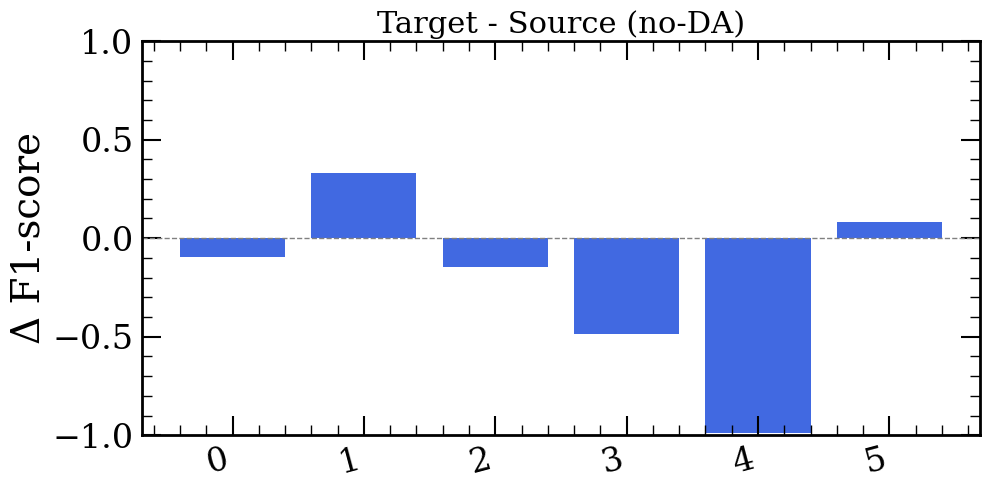

/home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/JPAS_DA/evaluation/evaluation_tools.py:1193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


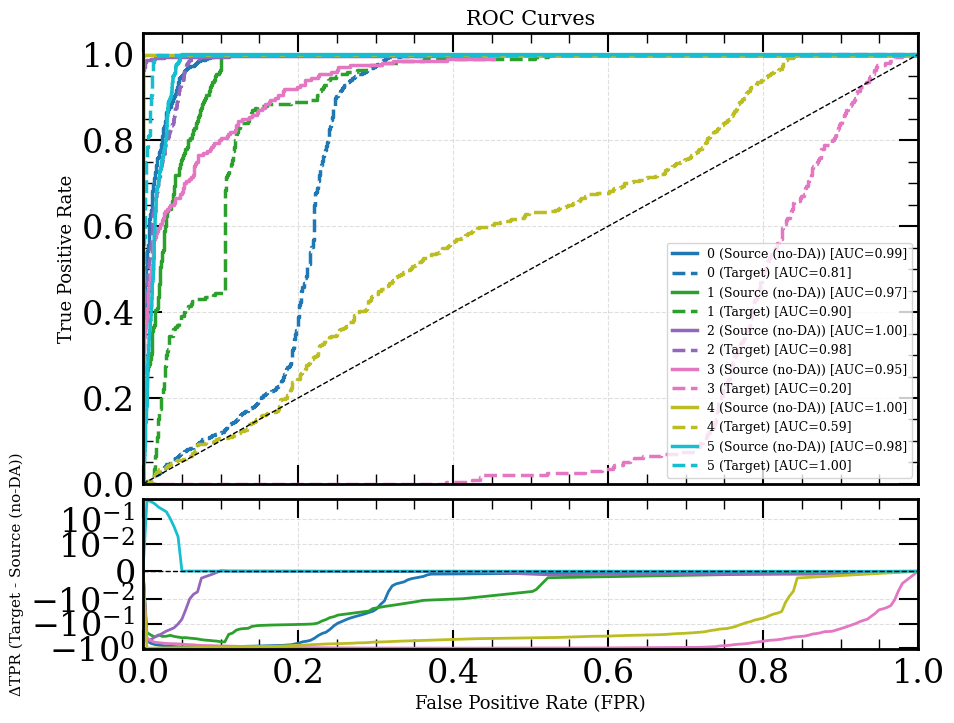


=== no-DA (Target) vs DA Metrics ===
Metric                        no-DA (Target)          DAΔ (DA - no-DA (Target))
-------------------------------------------------------------------------------
Accuracy                            0.7282      0.8217            0.0935
Macro F1                            0.5141      0.7363            0.2222
Macro TPR                           0.5274      0.7527            0.2253
Macro Precision                     0.5286      0.7803            0.2517
Macro AUROC                         0.7341      0.9603            0.2261
Expected Calibration Error          0.2005      0.0733           -0.1272
Brier Score                         0.5102      0.2990           -0.2112


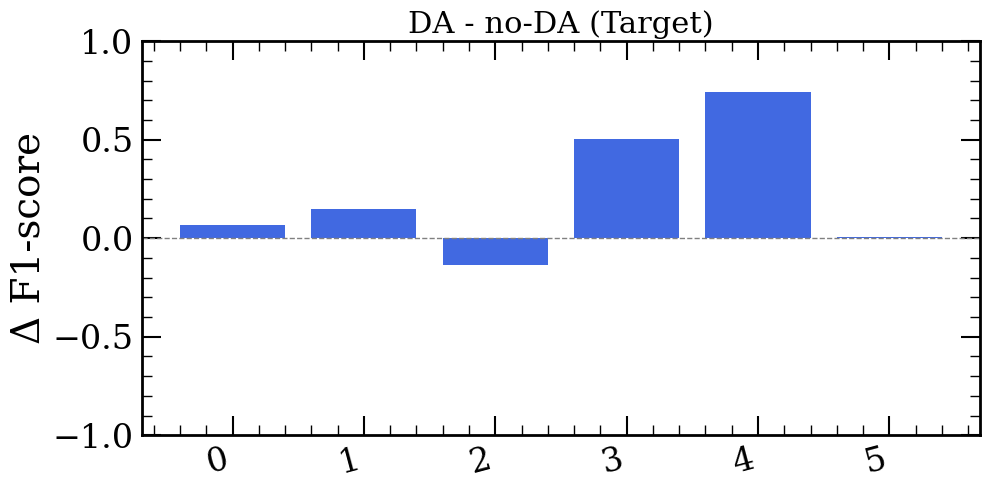

/home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/JPAS_DA/evaluation/evaluation_tools.py:1193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


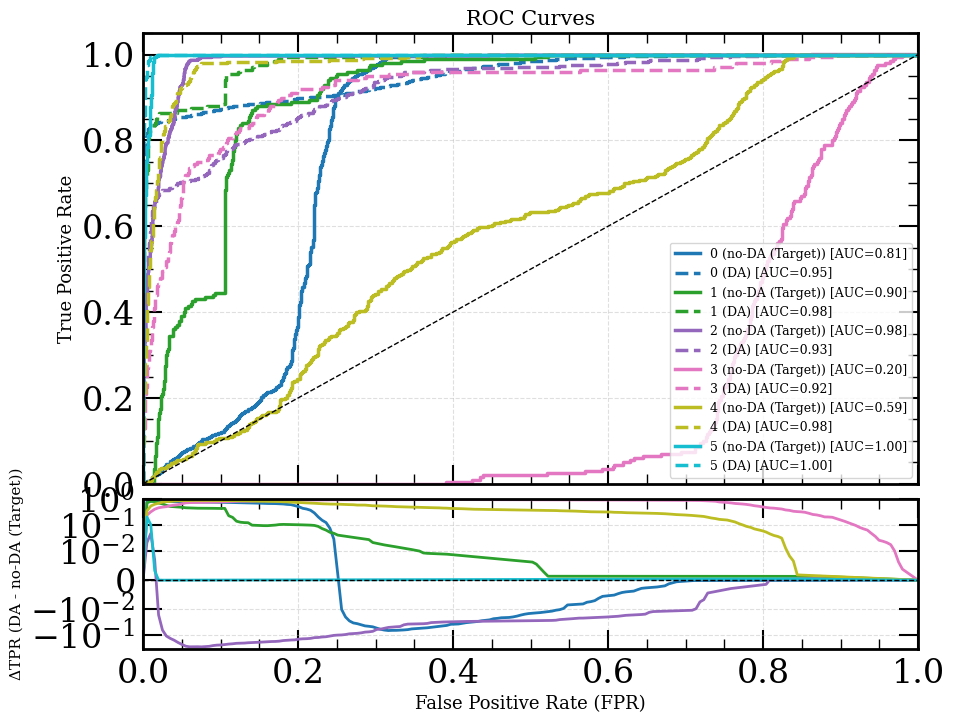

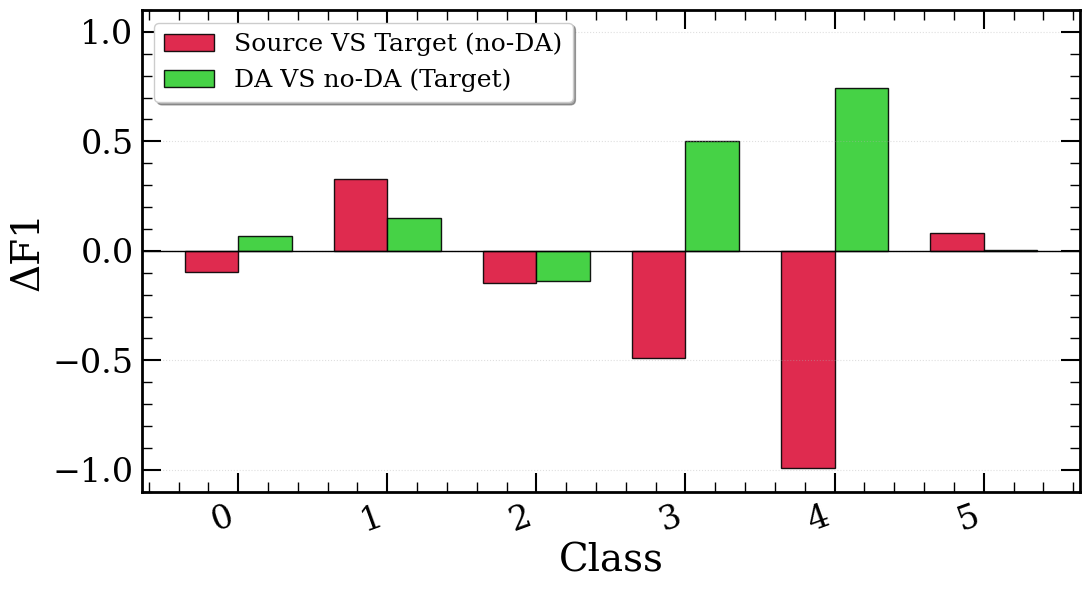

In [10]:
metrics = evaluation_tools.compare_sets_performance(
    yy_true_val_no_DA, yy_pred_P_val_no_DA,
    yy_true_test, yy_pred_P_test_no_DA,
    class_names=np.arange(n_classes),
    name_1="Source (no-DA)",
    name_2="Target",
    y_max_Delta_F1=1.0,
    y_min_Delta_F1=-1.0,
    f1_save_path=os.path.join(global_setup.path_saved_figures, "toy_F1_comparison_source_vs_target_no_DA.pdf")
)

metrics = evaluation_tools.compare_sets_performance(
    yy_true_test, yy_pred_P_test_no_DA,
    yy_true_test, yy_pred_P_test_DA,
    class_names=np.arange(n_classes),
    name_1="no-DA (Target)",
    name_2="DA",
    y_max_Delta_F1=1.0,
    y_min_Delta_F1=-1.0,
    f1_save_path=os.path.join(global_setup.path_saved_figures, "toy_F1_comparison_DA_vs_no_DA.pdf")
)

fig, ax = evaluation_tools.plot_overall_deltaF1_two_comparisons(
    y_true_src   = yy_true_val_no_DA,
    y_pred_src_noDA = yy_pred_P_val_no_DA,
    y_true_tgt   = yy_true_test,
    y_pred_tgt_noDA = yy_pred_P_test_no_DA,
    y_pred_tgt_DA   = yy_pred_P_test_DA,
    class_names=class_names,
    title=None,
    colors=("crimson", "limegreen"),
    labels=("Source VS Target (no-DA)", "DA VS no-DA (Target)"),
    ylim=(-1.1, 1.1),
    legend_kwargs={"loc":"upper left", "frameon":True, "fancybox":True, "shadow":True, "fontsize":18},
    save_dir=global_setup.path_saved_figures, save_format="pdf", save_dpi=250, filename="deltaF1"
)

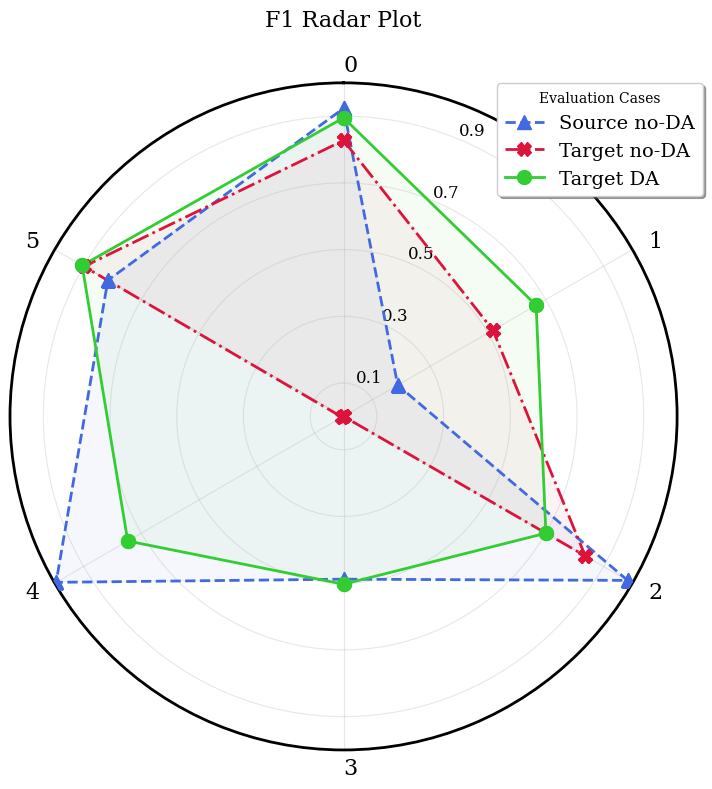

In [11]:
dict_radar = {
    "Source no-DA": {
        "y_true": yy_true_val_no_DA,
        "y_pred": yy_pred_P_val_no_DA,
        "plot_kwargs": {
            "linestyle": "--", "linewidth": 2.0, "color": "royalblue",
            "marker": "^", "markersize": 10.0, "fill_alpha": 0.05,
            "label": "Source no-DA"
        }
    },
    "Target no-DA": {
        "y_true": yy_true_test,
        "y_pred": yy_pred_P_test_no_DA,
        "plot_kwargs": {
            "linestyle": "-.", "linewidth": 2.0, "color": "crimson",
            "marker": "X", "markersize": 10.0, "fill_alpha": 0.05,
            "label": "Target no-DA"
        }
    },
    "Target DA": {
        "y_true": yy_true_test,
        "y_pred": yy_pred_P_test_DA,
        "plot_kwargs": {
            "linestyle": "-", "linewidth": 2.0, "color": "limegreen",
            "marker": "o", "markersize": 10.0, "fill_alpha": 0.05,
            "label": "Target DA"
        }
    },
}

fig, ax = evaluation_tools.radar_plot(
    dict_radar=dict_radar, class_names=class_names,
    title="F1 Radar Plot", figsize=(8, 8), theta_offset=np.pi / 2, # first axis at 12 o'clock
    r_ticks=(0.1, 0.3, 0.5, 0.7, 0.9), r_lim=(0.0, 1.0),
    tick_labelsize=16, radial_labelsize=12, show_legend=True,
    legend_kwargs={
        "loc": "upper left", "bbox_to_anchor": (0.73, 1.0), "fontsize": 14, "ncol": 1,
        "title": "Evaluation Cases", "frameon": True, "fancybox": True, "shadow": True, "borderaxespad": 0.0,
    }
)
fig.savefig(os.path.join(global_setup.path_saved_figures, "toy_F1_radar.pdf"), bbox_inches='tight')
plt.show()

# Explore latent space

In [12]:
feat_dict = {
    "latents_no_DA_Source": features_val_no_DA,
    "latents_no_DA_Target": features_test_no_DA,
    "latents_DA_Target": features_test_DA
}

latents_tSNE = evaluation_tools.tsne_per_key(
    feat_dict,
    standardize=False,
    subsample=None,
    random_state=137,
    tsne_kwargs={"perplexity": 100},
    return_all_key=None,
)

2025-09-26 13:21:36,882 - INFO - t-SNE on N=12000 (perplexity=100)...


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.002s...
[t-SNE] Computed neighbors for 12000 samples in 0.285s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.046819
[t-SNE] KL divergenc

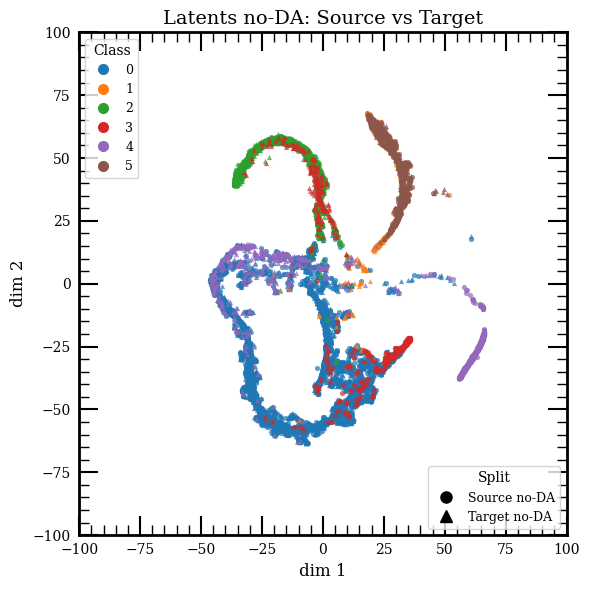

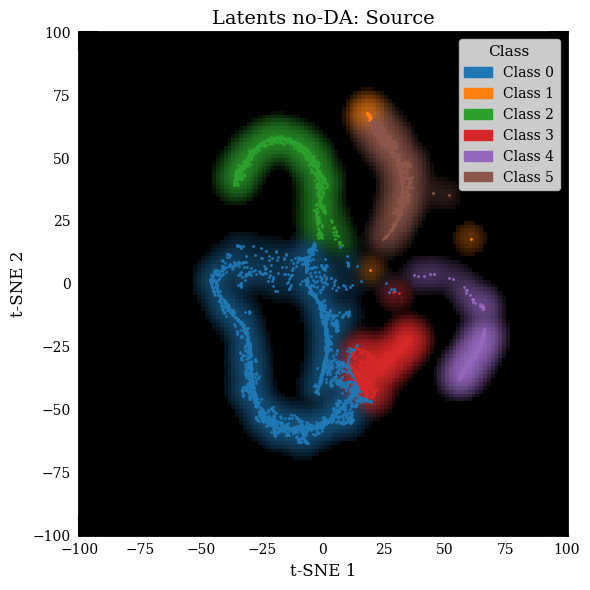

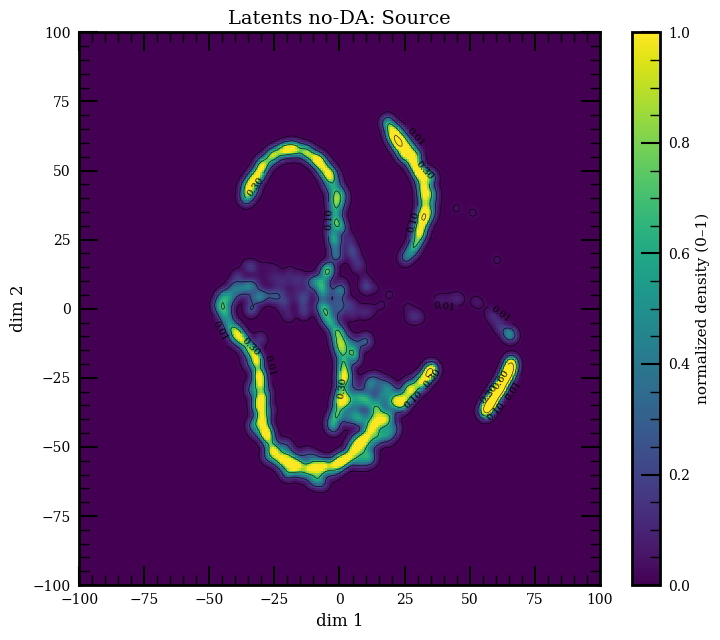

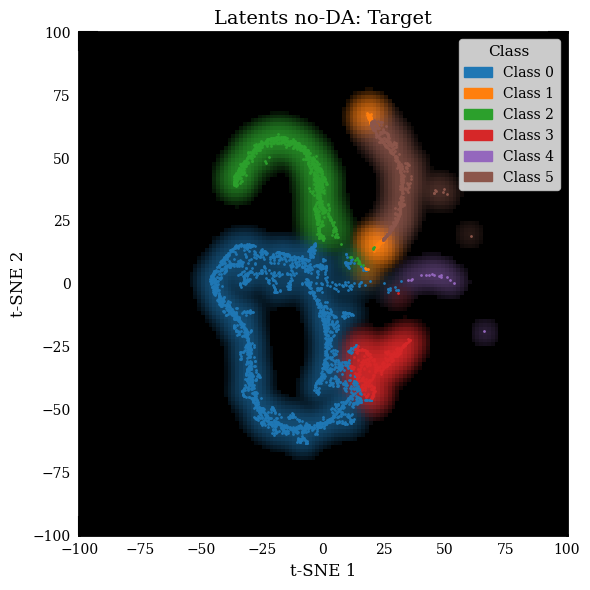

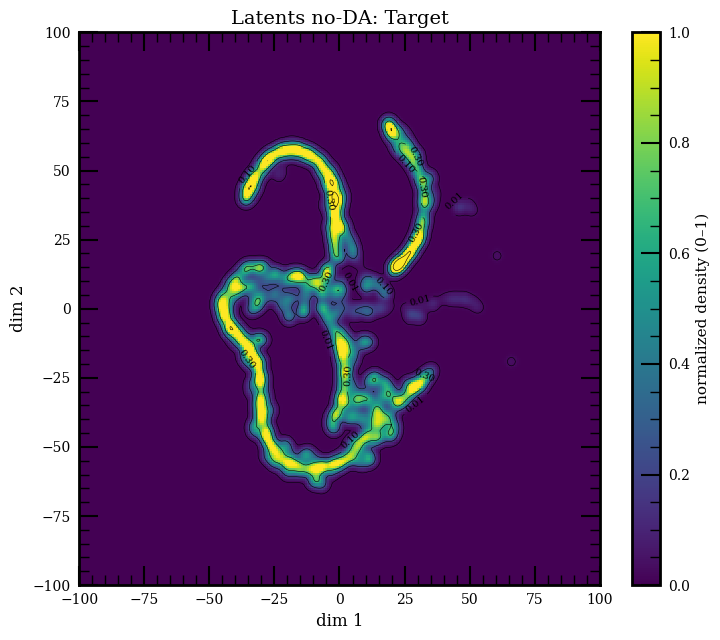

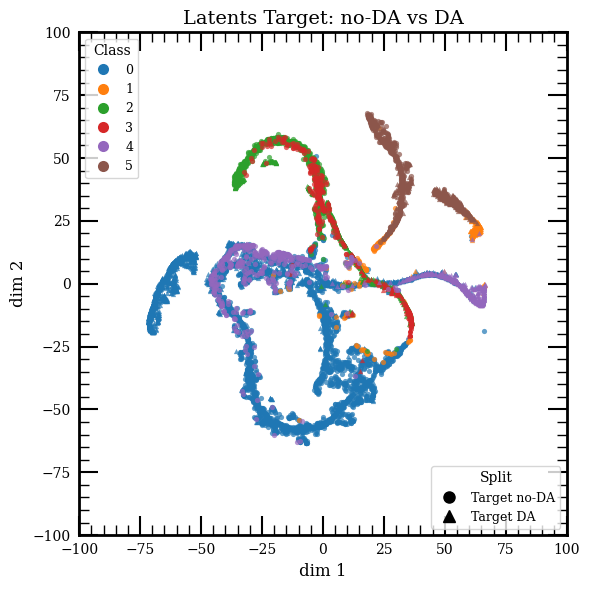

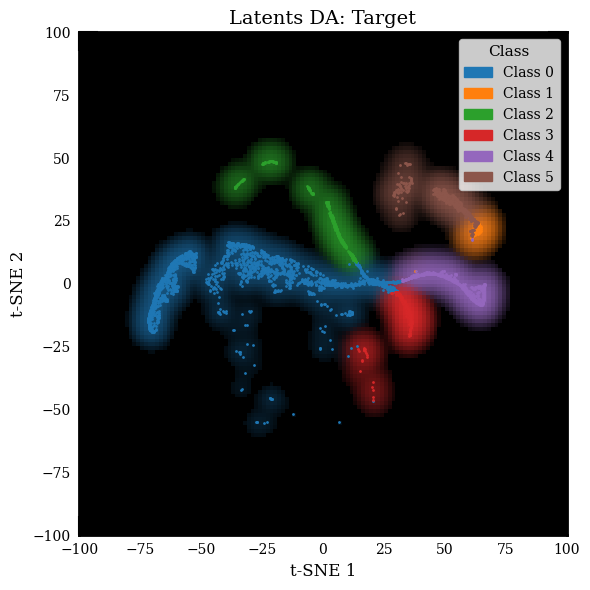

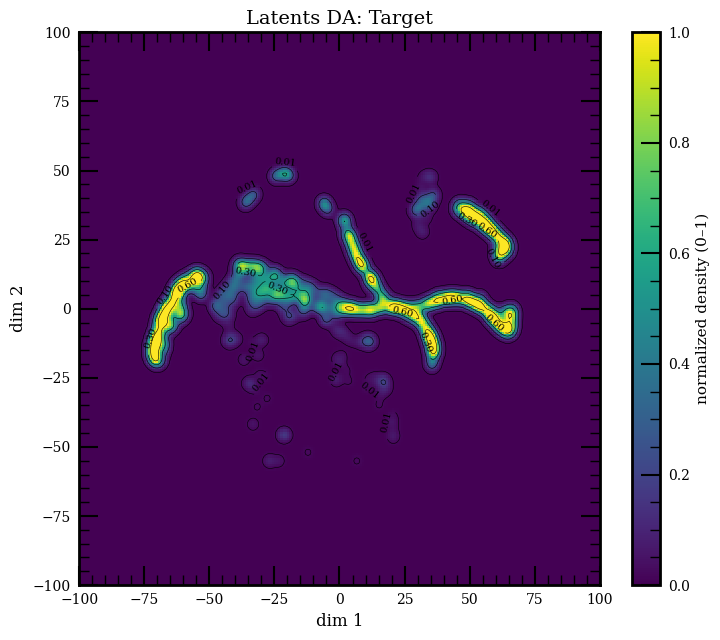

In [13]:
xlim = (-100, 100)
ylim = (-100, 100)

evaluation_tools.plot_latents_scatter_val_test(
    X_val=latents_tSNE['latents_no_DA_Source_tSNE'], y_val=yy_true_val_no_DA,
    X_test=latents_tSNE['latents_no_DA_Target_tSNE'], y_test=yy_true_test,
    class_names=None,
    title="Latents no-DA: Source vs Target",
    marker_val="o", marker_test="^",
    size_val=14, size_test=14, alpha_val=0.7, alpha_test=0.7,
    xlim=xlim, ylim=ylim,
    subsample=4000, seed=137,
    edgecolor=None, linewidths=0.0,
    legend_split_1="Source no-DA",
    legend_split_2="Target no-DA"
)
evaluation_tools.plot_latents_scatter(
    latents_tSNE['latents_no_DA_Source_tSNE'], yy_pred_val_no_DA, # yy_true_val_no_DA
    class_counts=dset_val_no_DA.class_counts,
    class_names=None,
    title="Latents no-DA: Source",
    n_bins=128, sigma=2.0,
    scatter_size=1.0, scatter_alpha=1.0,
    xlim=xlim, ylim=ylim
)
evaluation_tools.plot_latent_density_2d(
    latents_tSNE['latents_no_DA_Source_tSNE'],
    title="Latents no-DA: Source",
    density_method="hist", # or "kde"
    bins=256,
    sigma=2.0, # ignored if density_method="kde"
    norm_mode="max",
    color_scale="linear",
    mask_zero_support=True,
    contour_fracs=(0.01, 0.1, 0.3, 0.6),
    contour_colors="k",
    contour_linewidths=0.4,
    contour_label_fontsize=7,
    contour_label_color="k",
    show_points=False,
    points_alpha=0.1,
    points_size=2,
    random_subsample=None,
    xlim=xlim,
    ylim=ylim
)
evaluation_tools.plot_latents_scatter(
    latents_tSNE['latents_no_DA_Target_tSNE'], yy_pred_test_no_DA, # yy_true_test
    class_counts=dset_test.class_counts,
    class_names=None,
    title="Latents no-DA: Target",
    n_bins=128, sigma=2.0,
    scatter_size=1.0, scatter_alpha=1.0,
    xlim=xlim, ylim=ylim
)
evaluation_tools.plot_latent_density_2d(
    latents_tSNE['latents_no_DA_Target_tSNE'],
    title="Latents no-DA: Target",
    density_method="hist", # or "kde"
    bins=256,
    sigma=2.0, # ignored if density_method="kde"
    norm_mode="max",
    color_scale="linear",
    mask_zero_support=True,
    contour_fracs=(0.01, 0.1, 0.3, 0.6),
    contour_colors="k",
    contour_linewidths=0.4,
    contour_label_fontsize=7,
    contour_label_color="k",
    show_points=False,
    points_alpha=0.1,
    points_size=2,
    random_subsample=None,
    xlim=xlim,
    ylim=ylim
)

evaluation_tools.plot_latents_scatter_val_test(
    X_val=latents_tSNE['latents_no_DA_Target_tSNE'], y_val=yy_true_test,
    X_test=latents_tSNE['latents_DA_Target_tSNE'], y_test=yy_true_test,
    class_names=None,
    title="Latents Target: no-DA vs DA",
    marker_val="o", marker_test="^",
    size_val=14, size_test=14, alpha_val=0.7, alpha_test=0.7,
    xlim=xlim, ylim=ylim,
    subsample=4000, seed=137,
    edgecolor=None, linewidths=0.0,
    legend_split_1="Target no-DA",
    legend_split_2="Target DA"
)
evaluation_tools.plot_latents_scatter(
    latents_tSNE['latents_DA_Target_tSNE'], yy_pred_test_DA, # yy_true_test
    class_counts=dset_test.class_counts,
    class_names=None,
    title="Latents DA: Target",
    n_bins=128, sigma=2.0,
    scatter_size=1.0, scatter_alpha=1.0,
    xlim=xlim, ylim=ylim
)
evaluation_tools.plot_latent_density_2d(
    latents_tSNE['latents_DA_Target_tSNE'],
    title="Latents DA: Target",
    density_method="hist", # or "kde"
    bins=256,
    sigma=2.0, # ignored if density_method="kde"
    norm_mode="max",
    color_scale="linear",
    mask_zero_support=True,
    contour_fracs=(0.01, 0.1, 0.3, 0.6),
    contour_colors="k",
    contour_linewidths=0.4,
    contour_label_fontsize=7,
    contour_label_color="k",
    show_points=False,
    points_alpha=0.1,
    points_size=2,
    random_subsample=None,
    xlim=xlim,
    ylim=ylim
)